# Analyzing galaxies in the NDWFS Boötes field

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from time import time
start_time=time()

## Opening file and reading data onto a dataframe

In [2]:
# Selecting columns to read:
columns = ['ID','Z_BEST','Mass_median','Ks_flux','u_flux','R_rest','J_rest','F_MIPS_24','FErr_MIPS_24_u','FErr_MIPS_24_l','F_PACS_100','F_SPIRE_500','AGN','ch1_flux','ch2_flux','ch3_flux','ch4_flux','FLAG_CLEAN','FLAG_OVERLAP','FLAG_DEEP']
start_time1 = time()
# Reading the data:
bootes = pd.read_csv('/home/bruno/Documents/COSMOamautas/boote_catalogue.csv',usecols=columns)
end_time1 = time()
print(f"Creating dataframe took {end_time1-start_time1:.4g} seconds!")
bootes.info()
print(f"Number of galaxies in catalogue: {len(bootes)}")

Creating dataframe took 105.8 seconds!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2214329 entries, 0 to 2214328
Data columns (total 20 columns):
 #   Column          Dtype  
---  ------          -----  
 0   ID              float64
 1   FLAG_DEEP       int64  
 2   FLAG_OVERLAP    int64  
 3   FLAG_CLEAN      int64  
 4   u_flux          float64
 5   Ks_flux         float64
 6   ch1_flux        float64
 7   ch2_flux        float64
 8   ch3_flux        float64
 9   ch4_flux        float64
 10  F_MIPS_24       float64
 11  FErr_MIPS_24_u  float64
 12  FErr_MIPS_24_l  float64
 13  F_PACS_100      float64
 14  F_SPIRE_500     float64
 15  Z_BEST          float64
 16  AGN             int64  
 17  Mass_median     float64
 18  R_rest          float64
 19  J_rest          float64
dtypes: float64(16), int64(4)
memory usage: 337.9 MB
Number of galaxies in catalogue: 2214329


In [4]:
print(bootes['FLAG_DEEP'].value_counts())
print(bootes['FLAG_CLEAN'].value_counts())
print(bootes['FLAG_OVERLAP'].value_counts())
flag_criteria = '(FLAG_DEEP==1)&(FLAG_CLEAN==1)&(FLAG_OVERLAP==1)'

 1     1759885
 0      307005
-99     147439
Name: FLAG_DEEP, dtype: int64
1    1968481
3     245848
Name: FLAG_CLEAN, dtype: int64
1    2155780
0      58549
Name: FLAG_OVERLAP, dtype: int64


In [ ]:
bootes = bootes.query(flag_criteria)
print(f"Number of galaxies in sample: {len(bootes)}")

bootes['AGN'] = pd.to_numeric(bootes['AGN'], downcast='unsigned')
bootes['FLAG_DEEP'] = pd.to_numeric(bootes['FLAG_DEEP'], downcast='unsigned')
bootes['FLAG_CLEAN'] = pd.to_numeric(bootes['FLAG_CLEAN'], downcast='unsigned')
bootes['FLAG_OVERLAP'] = pd.to_numeric(bootes['FLAG_OVERLAP'], downcast='unsigned')
bootes['ID'] = pd.to_numeric(bootes['ID'], downcast='unsigned')

## Getting rid of invalid values

Since we will be selecting galaxies based on their rest-frame NUV-R and R-J colors, we shall first discard those entries with invalid values in these fields, such as 'nan' or 'inf', as well as those with negative fluxes in the Ks band. Because we are interested in studying galaxies at high redshift, we will also get rid of the entries with redshift values below 0.1.

In [5]:
pd.options.mode.use_inf_as_na = True
bootes.dropna(subset=['u_flux','R_rest','J_rest'],inplace=True)
bootes = bootes[(bootes['Ks_flux']>0) & (bootes['u_flux']>0) & (bootes['Z_BEST']>0) & (bootes['Z_BEST']<=1)]
print(f"Number of galaxies in sample: {len(bootes)}")

Number of galaxies in sample: 458761


## Getting rid of luminous AGN
We will discard entries of the catalog wich are likely to be luminous AGN and could thus be contaminating our sample. We will select them based on wether they are marked as AGN, or if they meet the IR AGN criteria presented by Donley et al. (2012).

In [ ]:
print(f"Entries flagged as optical, IR or X-ray AGN: {np.count_nonzero(bootes['AGN'])}")
bootes['x'] = np.log10(bootes['ch3_flux']/bootes['ch1_flux'])
bootes['y'] = np.log10(bootes['ch4_flux']/bootes['ch2_flux'])
Donley = '(x>=0.08)&(y>=0.15)&(y>=(1.21*x)-0.27)&(y<=(1.21*x)+0.27)&(ch4_flux>ch3_flux>ch2_flux>ch1_flux)'
print(f"Entries that meet the Donley et al. (2012) IR AGN criteria: {len(bootes.query(Donley))}")

In [ ]:
bootes = bootes.query('~('+Donley+')')
bootes = bootes[bootes['AGN']==0]
print(f"Number of galaxies in sample: {len(bootes)}")

## Redshift and stellar mass distribution

We can take a look at the distribution of important properties of the galaxies in our sample, such as redshift and stellar mass.

/home/bruno/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:403: RuntimeWarning: invalid value encountered in greater_equal
  keep = (a >= first_edge)
/home/bruno/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:404: RuntimeWarning: invalid value encountered in less_equal
  keep &= (a <= last_edge)
/home/bruno/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/bruno/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


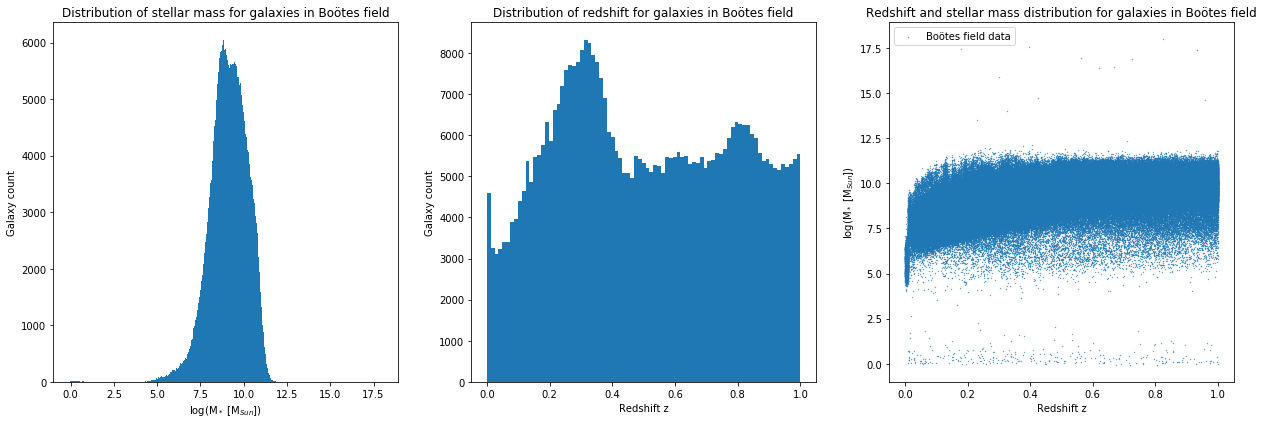

In [5]:
fig, ax = plt.subplots(1,3,figsize=(18,6))
# Plotting stellar mass histogram
ax[0].set_title('Distribution of stellar mass for galaxies in Boötes field')
ax[0].set_xlabel('log(M$_*$ [M$_{Sun}$])')
ax[0].set_ylabel('Galaxy count')
ax[0].hist(bootes['Mass_median'], 'auto')
# Plotting redshift histogram
ax[1].set_title('Distribution of redshift for galaxies in Boötes field')
ax[1].set_xlabel('Redshift z')
ax[1].set_ylabel('Galaxy count')
ax[1].hist(bootes['Z_BEST'], 'auto')
# Plotting Stellar mass vs Redshift
ax[2].set_title('Redshift and stellar mass distribution for galaxies in Boötes field')
ax[2].set_xlabel("Redshift z",fontsize=10)
ax[2].set_ylabel("log(M$_*$ [M$_{Sun}$])",fontsize=10)
ax[2].scatter(bootes['Z_BEST'],bootes['Mass_median'],s=0.1,label='Boötes field data')
ax[2].legend(numpoints=1, loc='best')
fig.tight_layout()
plt.show()

## Ks magnitude distribution

We can also check the distribution of galaxies according to their flux and magnitude in the Ks band. To obtain the magnitudes in the AB system, we shall create a function to perform the appropriate conversion.

In [6]:
def uJyToAB(fluxuJy):
    '''Converts flux in micro Jansky to AB magnitude, with a zeropoint of ~ 3631 Jansky
    Conversion taken from www.star.bristol.ac.uk/~mbt/stilts/sun256/uk.ac.starlink.ttools.func.Fluxes.html'''
    return 23.9-2.5*np.log10(fluxuJy) #2.5*(23+6-np.log10(fluxuJy))-48.6

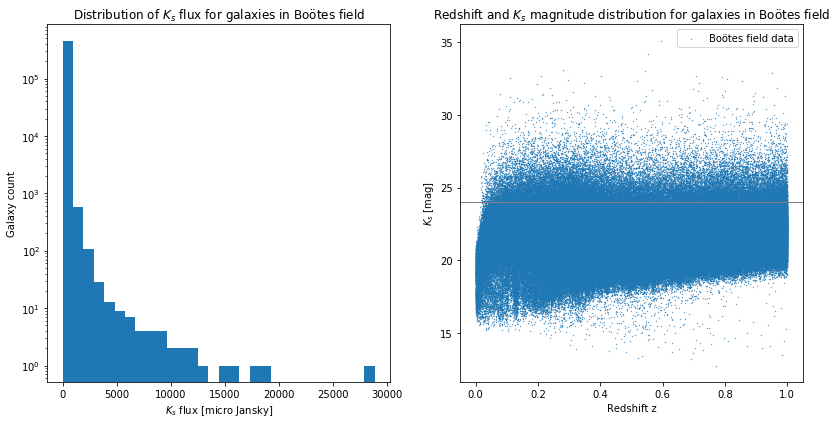

In [7]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
# Plotting Ks flux histogram
ax[0].set_title('Distribution of $K_s$ flux for galaxies in Boötes field')
ax[0].set_xlabel('$K_s$ flux [micro Jansky]')
ax[0].set_ylabel('Galaxy count')
ax[0].set_yscale('log')
ax[0].hist(bootes['Ks_flux'], bins=30)#'auto')
# Plotting Ks magnitude vs Redshift
ax[1].set_title('Redshift and $K_s$ magnitude distribution for galaxies in Boötes field')
ax[1].set_xlabel("Redshift z",fontsize=10)
ax[1].set_ylabel("$K_s$ [mag]",fontsize=10)
ax[1].scatter(bootes['Z_BEST'],uJyToAB(bootes['Ks_flux']),s=0.1,label='Boötes field data')
ax[1].axhline(24,color='0.5',linewidth=1)
ax[1].legend(numpoints=1, loc='best')
fig.tight_layout()
plt.show()

Because the colors have saturated in the scatter plot, using a 2D histogram allows us to better see the distribution of redshifts and magnitudes.

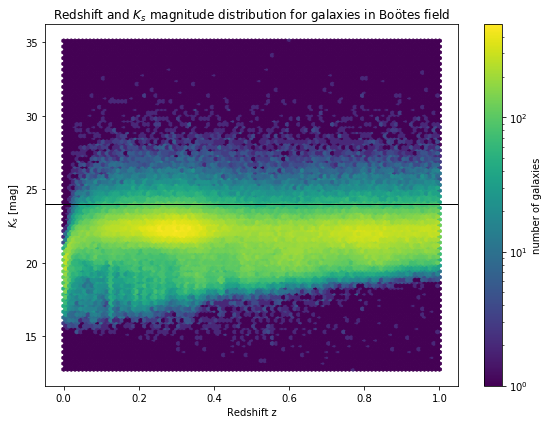

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
# Plotting Ks magnitude vs Redshift
ax.set_title('Redshift and $K_s$ magnitude distribution for galaxies in Boötes field')
ax.set_xlabel("Redshift z",fontsize=10)
ax.set_ylabel("$K_s$ [mag]",fontsize=10)
hb = ax.hexbin(bootes['Z_BEST'],uJyToAB(bootes['Ks_flux']),bins='log',label='Boötes field data')
cb = fig.colorbar(hb, ax=ax)
cb.set_label('number of galaxies')
ax.axhline(24,color='k',linewidth=1)
#ax.legend(numpoints=1, loc='best')
fig.tight_layout()
plt.show()

Following the sample specifications of Ilbert et al. 2013 and Man et al. 2016, we will limit our sample to those galaxies with Ks < 24. As can be seen in the figure above, the majority of the sample is still included after applying this cut.

In [7]:
# Making cut in Ks magnitude
bootes = bootes[uJyToAB(bootes['Ks_flux'])<24]
print(f"Number of galaxies in sample: {len(bootes)}")

Number of galaxies in sample: 424311


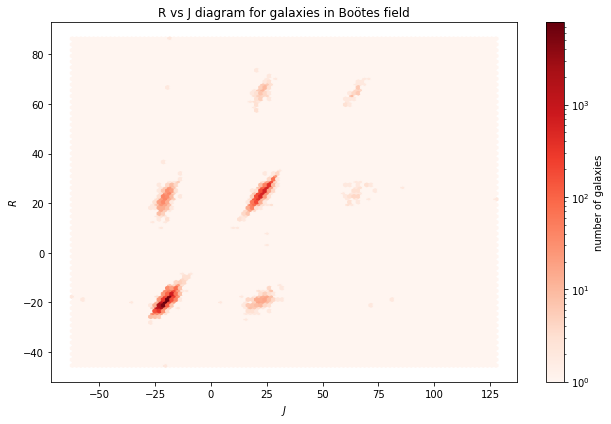

In [10]:
fig, axs = plt.subplots(figsize=(9,6))
axs.set_title('R vs J diagram for galaxies in Boötes field')
axs.set_xlabel(f"$J$",fontsize=10)
axs.set_ylabel(f"$R$",fontsize=10)
hb = axs.hexbin(bootes.query('0.5<Z_BEST<0.6').loc[:,'J_rest'],bootes.query('0.5<Z_BEST<0.6').loc[:,'R_rest'],bins='log',cmap='Reds')
cb = fig.colorbar(hb, ax=axs)
cb.set_label('number of galaxies')
fig.tight_layout()
plt.show()

# Defining magnitudes in GALEX NUV band

We are interested in selecting galaxies according to their NUV-r-J colors. Since we don't have NUV rest-frame magnitudes available, we can calculate them for those galaxies whose rest-frame NUV flux is traced by the u band flux in the observed frame. Asuming u and NUV effective wavelengths of 3520 and 2271 Angstroms, respectively, this corresponds to galaxies at redshift ~0.55.

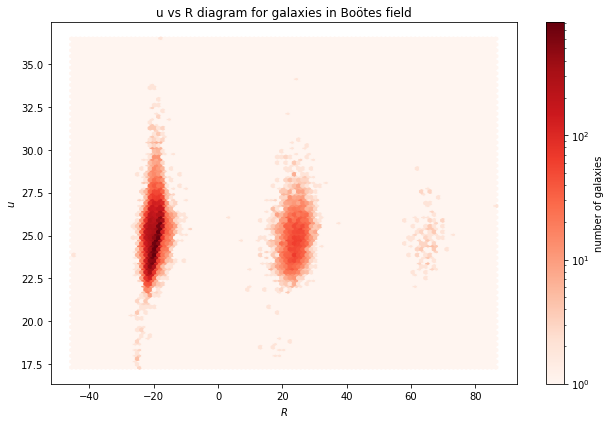

In [11]:
fig, axs = plt.subplots(figsize=(9,6))
axs.set_title('u (apparent) vs R diagram for galaxies in Boötes field')
axs.set_xlabel(f"$R$",fontsize=10)
axs.set_ylabel(f"$u (apparent)$",fontsize=10)
hb = axs.hexbin(bootes.query('0.5<Z_BEST<0.6').loc[:,'R_rest'],uJyToAB(bootes.query('0.5<Z_BEST<0.6').loc[:,'u_flux']),bins='log',cmap='Reds')
cb = fig.colorbar(hb, ax=axs)
cb.set_label('number of galaxies')
fig.tight_layout()
plt.show()

Using the previously defined uJyToAB function to calculate the AB magnitudes from the measured flux gives values close to 25. This is because we are getting apparent magnitudes, which are going to be high for very distant, faint galaxies. Instead, we can convert these to absolute magnitudes by subtracting the distance modulus, obtained using the respective luminosity distance for each redshift measurement.

In [8]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
# Asuming u and NUV effective wavelengths of 3520 and 2271 Angstroms, respectively
# NUV_rest = uJyToAB(u_flux) - dist_modulus = uJyToAB(u_flux) + 5 - 5*log(lum_dist/pc)
# NUV_rest = uJyToAB(u_flux) - dist_modulus = uJyToAB(u_flux) + 5 - 5*log(lum_dist*10^6)
# NUV_rest = uJyToAB(u_flux) - dist_modulus = uJyToAB(u_flux) + 5 - 5*log(lum_dist) - 5*6
# NUV_rest = uJyToAB(u_flux) - dist_modulus = uJyToAB(u_flux) -25 - 5*log(lum_dist)
# lum_dist = cosmo.luminosity_distance(zobj).value
bootes['NUV_rest'] = pd.Series([uJyToAB(flux) -25 - 5*np.log10(cosmo.luminosity_distance(zobj).value) for flux, zobj in zip(bootes['u_flux'],bootes['Z_BEST'])],index=bootes.index)

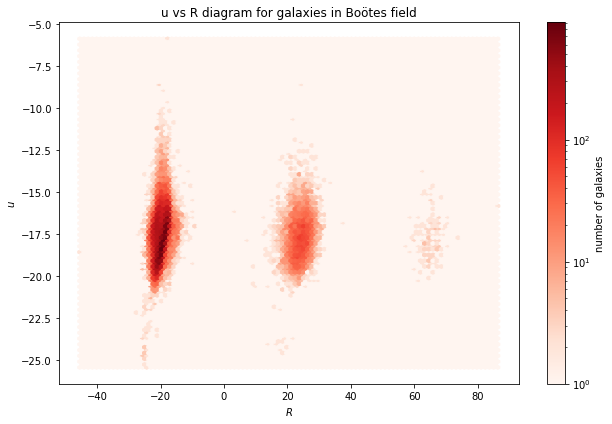

In [13]:
fig, axs = plt.subplots(figsize=(9,6))
axs.set_title('NUV vs R diagram for galaxies in Boötes field')
axs.set_xlabel(f"$R$",fontsize=10)
axs.set_ylabel(f"$NUV$",fontsize=10)
hb = axs.hexbin(bootes.query('0.5<Z_BEST<0.6').loc[:,'R_rest'],bootes.query('0.5<Z_BEST<0.6').loc[:,'NUV_rest'],bins='log',cmap='Reds')
cb = fig.colorbar(hb, ax=axs)
cb.set_label('number of galaxies')
fig.tight_layout()
plt.show()

Now we are getting values close to -18, which are to be expected for absolute magnitueds since galaxies are intrinsically very bright.

## Exploring color-color space

By choosing three rest-frame bands (in this case, NUV, R and J), we can define two colors which we will use to select galaxies as quiescent or star-forming. In order to have easy acces to these colors for later operations, we will add two new columns to the table based on the values of other columns.

In [9]:
filter1 = 'NUV'
filter2 = 'R'
filter3 = 'J'
bootes['NUVR'] = bootes['NUV_rest']-bootes['R_rest']
bootes['RJ'] = bootes['R_rest']-bootes['J_rest']

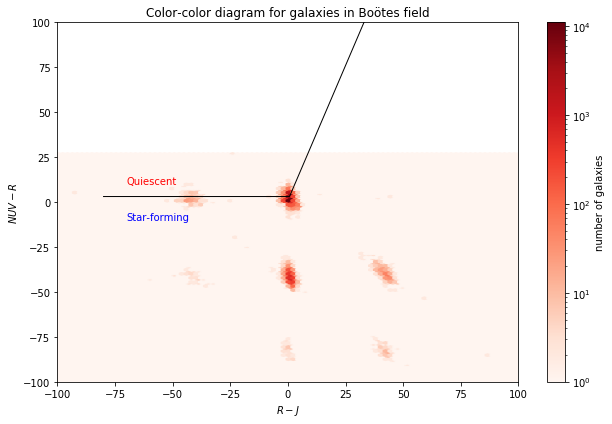

In [10]:
fig, axs = plt.subplots(figsize=(9,6))
axs.set_title('Color-color diagram for galaxies in Boötes field')
axs.set_xlabel(f"${filter2}-{filter3}$",fontsize=10)
axs.set_ylabel(f"${filter1}-{filter2}$",fontsize=10)
hb = axs.hexbin(bootes.query('0.5<Z_BEST<0.6').loc[:,'RJ'],bootes.query('0.5<Z_BEST<0.6').loc[:,'NUVR'],bins='log',cmap='Reds')
cb = fig.colorbar(hb, ax=axs)
cb.set_label('number of galaxies')
axs.plot([-80,0.7,80],[3.1,3.1,241],color='k',linewidth=1,label='Color selection boundary')
axs.set_xlim(xmin=-100,xmax=100)
axs.set_ylim(ymin=-100,ymax=30)
axs.text(-70,10,'Quiescent',size=10,color='r')
axs.text(-70,-10,'Star-forming',size=10,color='b')
fig.tight_layout()
plt.show()

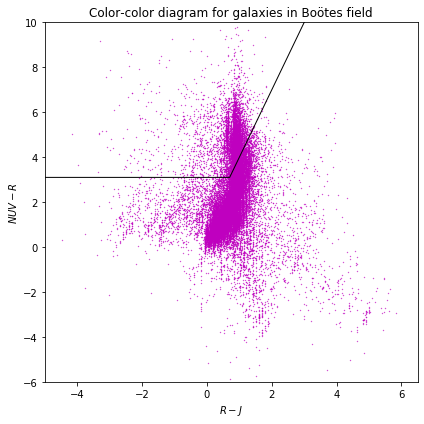

In [18]:
fig, axs = plt.subplots(figsize=(6,6))
axs.set_title('Color-color diagram for galaxies in Boötes field')
axs.set_xlabel(f"${filter2}-{filter3}$",fontsize=10)
axs.set_ylabel(f"${filter1}-{filter2}$",fontsize=10)
axs.scatter(bootes.query('0.5<Z_BEST<0.6').loc[:,'RJ'],bootes.query('0.5<Z_BEST<0.6').loc[:,'NUVR'],c='m',s=0.1)
axs.plot([-80,0.7,80],[3.1,3.1,241],color='k',linewidth=1,label='Color selection boundary')
axs.set_xlim(xmin=-5,xmax=6.5)
axs.set_ylim(ymin=-6,ymax=10)
#axs.text(-70,10,'Quiescent',size=10,color='r')
#axs.text(-70,-10,'Star-forming',size=10,color='b')
fig.tight_layout()
plt.show()

We see that there is a large spread in the distribution of galaxies in this color-color space, which could be an artifact of the SED fitting used to get the rest-frame magnitudes, and the fact that we are including galaxies with ~0.05 dispersion around z = 0.55. We will now restrict our sample to the galaxies within the central region of this plane.

In [12]:
# TRY bootes = bootes.loc[(bootes['NUVR']>=-6)&(bootes['NUVR']<=10)&(bootes['RJ']>=-5)&(bootes['RJ']<=6.5),:]
bootes = bootes[
    (bootes['NUVR']>=-6) &
    (bootes['NUVR']<=10) &
    (bootes['RJ']>=-5) &
    (bootes['RJ']<=6.5)]

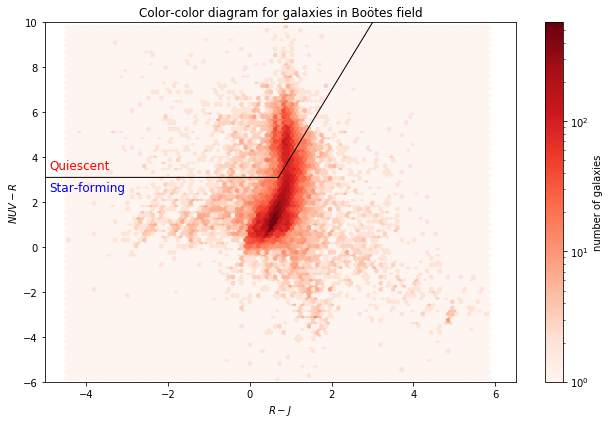

In [19]:
fig, axs = plt.subplots(figsize=(9,6))
axs.set_title('Color-color diagram for galaxies in Boötes field')
axs.set_xlabel(f"${filter2}-{filter3}$",fontsize=10)
axs.set_ylabel(f"${filter1}-{filter2}$",fontsize=10)
hb = axs.hexbin(bootes.query('0.5<Z_BEST<0.6').loc[:,'RJ'],bootes.query('0.5<Z_BEST<0.6').loc[:,'NUVR'],bins='log',cmap='Reds')
cb = fig.colorbar(hb, ax=axs)
cb.set_label('number of galaxies')
axs.plot([-80,0.7,80],[3.1,3.1,241],color='k',linewidth=1,label='Color selection boundary')
axs.set_xlim(xmin=-5,xmax=6.5)
axs.set_ylim(ymin=-6,ymax=10)
axs.text(-4.9,3.5,'Quiescent',size=12,color='r')
axs.text(-4.9,2.5,'Star-forming',size=12,color='b')
fig.tight_layout()
plt.show()

We can calculate the fraction of galaxies within the 'quiescent region', and the fraction of those that have viable data at 24 micron from MIPS.

In [20]:
#bootes = bootes[(bootes['Z_BEST']>=0.5)&(bootes['Z_BEST']<=0.6)]

In [ ]:
quiescent = '((NUVR>3.1)&(NUVR>3*RJ+1))'
SF = '((NUVR<=3.1)|(NUVR<=3*RJ+1))'
MIPSSNR3 = '(F_MIPS_24>3*(FErr_MIPS_24_u-F_MIPS_24))&(F_MIPS_24>3*(F_MIPS_24-FErr_MIPS_24_l))'
MIPSSNR5 = '(F_MIPS_24>5*(FErr_MIPS_24_u-F_MIPS_24))&(F_MIPS_24>5*(F_MIPS_24-FErr_MIPS_24_l))'

In [22]:
final_sample = len(bootes)
n_quiescent = len(bootes.query(quiescent))
n_star_forming = len(bootes.query(SF))
print(f"Number of galaxies in sample: {final_sample}")
print(f"Number of quiescent galaxies in the sample: {n_quiescent}")
q_mass = len(bootes.query(quiescent).loc[np.isfinite(bootes['Mass_median']),:])
print(f"Fraction of quiescent galaxies with stellar mass data: {q_mass/n_quiescent:.2%}")
q_MIPS = len(bootes.query(quiescent).loc[np.isfinite(bootes['F_MIPS_24']),:])
print(f"Fraction of quiescent galaxies with MIPS data: {q_MIPS/n_quiescent:.2%}")
q_MIPSgt0 = len(bootes.query(quiescent+'&(F_MIPS_24>0)'))
print(f"Fraction of quiescent galaxies with MIPS flux > 0 uJy: {q_MIPSgt0/n_quiescent:.2%}")
q_MIPSSN = len(bootes.query(quiescent+'&'+MIPSSNR3))
print(f"Fraction of quiescent galaxies with MIPS S/N > 3: {q_MIPSSN/n_quiescent:.2%}")
q_MIPSSN = len(bootes.query(quiescent+'&'+MIPSSNR5))
print(f"Fraction of quiescent galaxies with MIPS S/N > 5: {q_MIPSSN/n_quiescent:.2%}")
print("")
print(f"Number of star-forming galaxies in the sample: {n_star_forming}")
sf_mass = len(bootes.query(SF).loc[np.isfinite(bootes['Mass_median']),:])
print(f"Fraction of star-forming galaxies with stellar mass data: {sf_mass/n_star_forming:.2%}")
sf_MIPS = len(bootes.query(SF).loc[np.isfinite(bootes['F_MIPS_24']),:])
print(f"Fraction of star-forming galaxies with MIPS data: {sf_MIPS/n_star_forming:.2%}")
sf_MIPSgt0 = len(bootes.query(SF+'&(F_MIPS_24>0)'))
print(f"Fraction of star-forming galaxies with MIPS flux > 0 uJy: {sf_MIPSgt0/n_star_forming:.2%}")
sf_MIPSSN = len(bootes.query(SF+'&'+MIPSSNR3))
print(f"Fraction of star-forming galaxies with MIPS S/N > 3: {sf_MIPSSN/n_star_forming:.2%}")
sf_MIPSSN = len(bootes.query(SF+'&'+MIPSSNR5))
print(f"Fraction of star-forming galaxies with MIPS S/N > 5: {sf_MIPSSN/n_star_forming:.2%}")

Number of galaxies in sample: 34323
Number of quiescent galaxies in the sample: 5692
Fraction of quiescent galaxies with stellar mass data: 94.80%
Fraction of quiescent galaxies with MIPS data: 93.80%
Fraction of quiescent galaxies with MIPS flux > 0 uJy: 84.17%
Fraction of quiescent galaxies with MIPS S/N > 3: 24.93%
Fraction of quiescent galaxies with MIPS S/N > 5: 14.56%

Number of star-forming galaxies in the sample: 28631
Fraction of star-forming galaxies with stellar mass data: 98.51%
Fraction of star-forming galaxies with MIPS data: 92.30%
Fraction of star-forming galaxies with MIPS flux > 0 uJy: 65.35%
Fraction of star-forming galaxies with MIPS S/N > 3: 28.19%
Fraction of star-forming galaxies with MIPS S/N > 5: 19.26%


Seeing that our sub-samples have large fractions with stellar mass data, we will now restrict the sample to only include those galaxies with available stellar mass. We will also exclude galaxies with unlikely values of stellar mass, i. e. those below 1000 solar masses.

In [23]:
bootes = bootes[bootes['Mass_median']>=3]
final_sample=len(bootes)
n_quiescent = len(bootes.query(quiescent))
n_star_forming = len(bootes.query(SF))
print(f"Number of galaxies in sample: {final_sample}")
print(f"Number of quiescent galaxies in the sample: {n_quiescent}")
q_mass = len(bootes.query(quiescent).loc[np.isfinite(bootes['Mass_median']),:])
print(f"Fraction of quiescent galaxies with stellar mass data: {q_mass/n_quiescent:.2%}")
q_MIPS = len(bootes.query(quiescent).loc[np.isfinite(bootes['F_MIPS_24']),:])
print(f"Fraction of quiescent galaxies with MIPS data: {q_MIPS/n_quiescent:.2%}")
q_MIPSgt0 = len(bootes.query(quiescent+'&(F_MIPS_24>0)'))
print(f"Fraction of quiescent galaxies with MIPS flux > 0 uJy: {q_MIPSgt0/n_quiescent:.2%}")
q_MIPSSN = len(bootes.query(quiescent+'&'+MIPSSNR3))
print(f"Fraction of quiescent galaxies with MIPS S/N > 3: {q_MIPSSN/n_quiescent:.2%}")
q_MIPSSN = len(bootes.query(quiescent+'&'+MIPSSNR5))
print(f"Fraction of quiescent galaxies with MIPS S/N > 5: {q_MIPSSN/n_quiescent:.2%}")
print("")
print(f"Number of star-forming galaxies in the sample: {n_star_forming}")
sf_mass = len(bootes.query(SF).loc[np.isfinite(bootes['Mass_median']),:])
print(f"Fraction of star-forming galaxies with stellar mass data: {sf_mass/n_star_forming:.2%}")
sf_MIPS = len(bootes.query(SF).loc[np.isfinite(bootes['F_MIPS_24']),:])
print(f"Fraction of star-forming galaxies with MIPS data: {sf_MIPS/n_star_forming:.2%}")
sf_MIPSgt0 = len(bootes.query(SF+'&(F_MIPS_24>0)'))
print(f"Fraction of star-forming galaxies with MIPS flux > 0 uJy: {sf_MIPSgt0/n_star_forming:.2%}")
sf_MIPSSN = len(bootes.query(SF+'&'+MIPSSNR3))
print(f"Fraction of star-forming galaxies with MIPS S/N > 3: {sf_MIPSSN/n_star_forming:.2%}")
sf_MIPSSN = len(bootes.query(SF+'&'+MIPSSNR5))
print(f"Fraction of star-forming galaxies with MIPS S/N > 5: {sf_MIPSSN/n_star_forming:.2%}")

Number of galaxies in sample: 33576
Number of quiescent galaxies in the sample: 5387
Fraction of quiescent galaxies with stellar mass data: 100.00%
Fraction of quiescent galaxies with MIPS data: 93.73%
Fraction of quiescent galaxies with MIPS flux > 0 uJy: 83.61%
Fraction of quiescent galaxies with MIPS S/N > 3: 25.19%
Fraction of quiescent galaxies with MIPS S/N > 5: 14.59%

Number of star-forming galaxies in the sample: 28189
Fraction of star-forming galaxies with stellar mass data: 100.00%
Fraction of star-forming galaxies with MIPS data: 92.39%
Fraction of star-forming galaxies with MIPS flux > 0 uJy: 65.09%
Fraction of star-forming galaxies with MIPS S/N > 3: 27.95%
Fraction of star-forming galaxies with MIPS S/N > 5: 19.09%


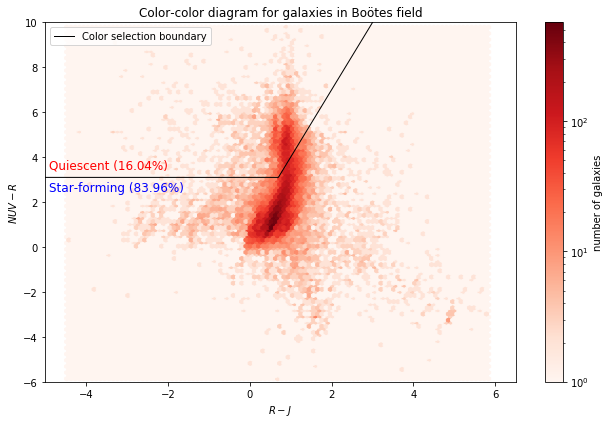

In [31]:
fig, axs = plt.subplots(figsize=(9,6))
axs.set_title('Color-color diagram for galaxies in Boötes field')
axs.set_xlabel(f"${filter2}-{filter3}$",fontsize=10)
axs.set_ylabel(f"${filter1}-{filter2}$",fontsize=10)
hb = axs.hexbin(bootes.query('0.5<Z_BEST<0.6').loc[:,'RJ'],bootes.query('0.5<Z_BEST<0.6').loc[:,'NUVR'],bins='log',cmap='Reds')
cb = fig.colorbar(hb, ax=axs)
cb.set_label('number of galaxies')
axs.plot([-80,0.7,80],[3.1,3.1,241],color='k',linewidth=1,label='Color selection boundary')
axs.legend(numpoints=1, loc='best')
axs.set_xlim(xmin=-5,xmax=6.5)
axs.set_ylim(ymin=-6,ymax=10)
axs.text(-4.9,3.5,f"Quiescent ({n_quiescent/final_sample:.2%})",size=12,color='r')
axs.text(-4.9,2.5,f"Star-forming ({n_star_forming/final_sample:.2%})",size=12,color='b')
fig.tight_layout()
plt.show()

Now we can take a look at the redshift and stellar mass distributions of our narrowed down sample.

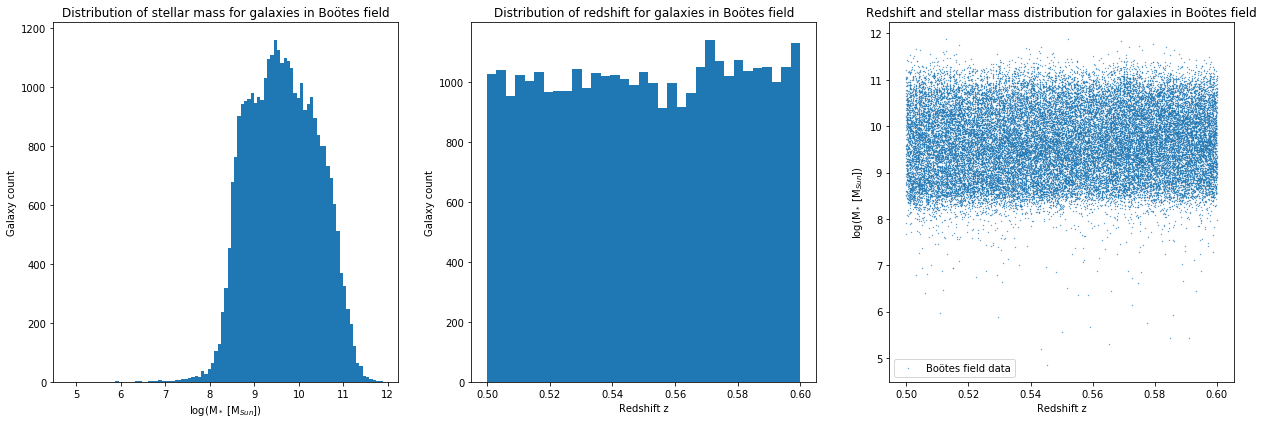

In [32]:
fig, ax = plt.subplots(1,3,figsize=(18,6))
# Plotting stellar mass histogram
ax[0].set_title('Distribution of stellar mass for galaxies in Boötes field')
ax[0].set_xlabel('log(M$_*$ [M$_{Sun}$])')
ax[0].set_ylabel('Galaxy count')
ax[0].hist(bootes['Mass_median'], 'auto')
# Plotting redshift histogram
ax[1].set_title('Distribution of redshift for galaxies in Boötes field')
ax[1].set_xlabel('Redshift z')
ax[1].set_ylabel('Galaxy count')
ax[1].hist(bootes['Z_BEST'], 'auto')
# Plotting Stellar mass vs Redshift
ax[2].set_title('Redshift and stellar mass distribution for galaxies in Boötes field')
ax[2].set_xlabel("Redshift z",fontsize=10)
ax[2].set_ylabel("log(M$_*$ [M$_{Sun}$])",fontsize=10)
ax[2].scatter(bootes['Z_BEST'],bootes['Mass_median'],s=0.1,label='Boötes field data')
ax[2].legend(numpoints=1, loc='best')
fig.tight_layout()
plt.show()

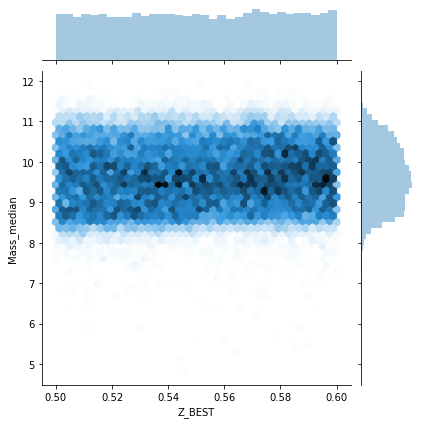

In [24]:
sns.jointplot(x=bootes['Z_BEST'], y=bootes['Mass_median'], kind="hex")#, color="k")

We can also see how the color-color diagram looks like after dividing the sample in three redshift bins.

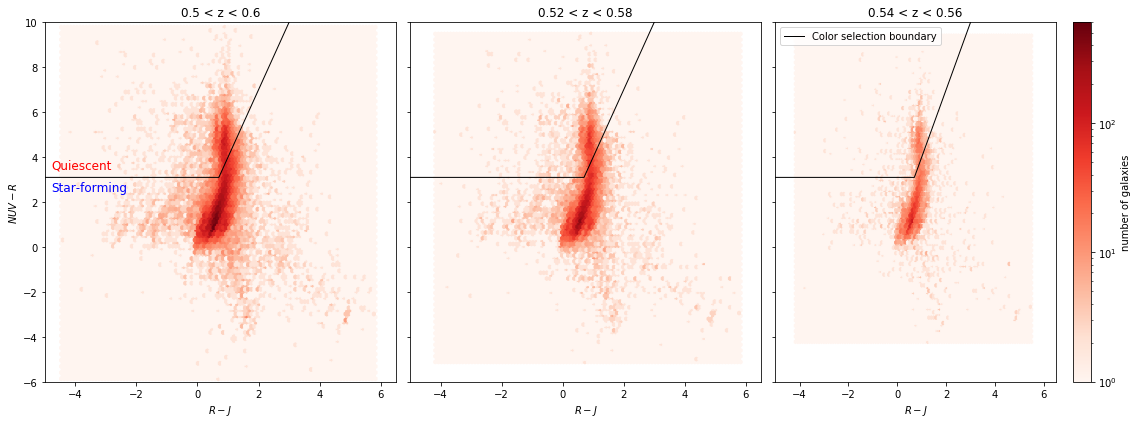

In [26]:
fig, axs = plt.subplots(1,3,sharey='row',figsize=(16,6))
#fig.suptitle('Color-color diagrams for different redshift bins')
fig.subplots_adjust(wspace=0)
for n, zmin, zmax in zip([0,1,2],[0.5,0.52,0.54],[0.6,0.58,0.56]):
    axs[n].set_xlabel(f"${filter2}-{filter3}$",fontsize=10)
    #xdata = bootes.loc[(bootes['Z_BEST']>=zmin)&(bootes['Z_BEST']<zmax),'RJ']
    #ydata = bootes.loc[(bootes['Z_BEST']>=zmin)&(bootes['Z_BEST']<zmax),'NUVR']
    xdata = bootes.query(f"{zmin}<=Z_BEST<={zmax}").loc[:,'RJ']
    ydata = bootes.query(f"{zmin}<=Z_BEST<={zmax}").loc[:,'NUVR']
    hb = axs[n].hexbin(xdata,ydata,bins='log',cmap='Reds',vmax=600)
    axs[n].plot([-80,0.7,80],[3.1,3.1,241],color='k',linewidth=1,label='Color selection boundary')
    axs[n].set_xlim(xmin=-5,xmax=6.5)
    axs[n].set_ylim(ymin=-6,ymax=10)
    axs[n].set_title(f"{zmin} < z < {zmax}")
cb = fig.colorbar(hb, ax=axs[2])
cb.set_label('number of galaxies')
axs[0].set_ylabel(f"${filter1}-{filter2}$",fontsize=10)
axs[2].legend(numpoints=1, loc='best')
axs[0].text(-4.8,3.5,'Quiescent',size=12,color='r')
axs[0].text(-4.8,2.5,'Star-forming',size=12,color='b')
fig.tight_layout()
plt.show()

## Estimating SFRs from MIPS 24 micron flux

Now we will estimate the star formation rate of individually detected galaxies with the 24 micron flux calibration by Rujopakarn et al. 2013.

In [27]:
from scipy.interpolate import interp1d

z = np.array([0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4,2.6,2.8])
Az = np.array([2.656,2.35,2.06,2.012,1.659,1.296,1.137,1.039,1.015,0.934,0.922,0.896,0.837,0.768,0.655])
Bz = np.array([0.975,1.02,1.056,1.065,1.094,1.129,1.159,1.179,1.165,1.149,1.145,1.149,1.158,1.175,1.198])
Az_intrp = interp1d(z, Az, kind='cubic')
Bz_intrp = interp1d(z, Bz, kind='cubic')

In [28]:
def F24_to_LIR(flux, zobj):
    '''Convert Spitzer/MIPS 24 micron flux and redshift to total IR
    luminosity according to Rujopakarn et al. (2013)    
    Input: flux in microJy, redshift
    Output: LIR in Lsun
    '''
    if (~np.isfinite(flux))|(zobj==0):
        return np.nan
    elif flux>0:
        Mpc_to_cm = 3.08568025*(10**24) # 1 Mpc in cm
        microJy_to_Jy = 10**(-6)        # 1 mJy in Jy
        D_L = cosmo.luminosity_distance(zobj).value*Mpc_to_cm # Luminosity distance in cm
        
        logLIR = Az_intrp(zobj) + Bz_intrp(zobj)*(np.log10(flux*microJy_to_Jy*4*np.pi*(D_L**2)) - 45)
        return 10**logLIR
    else:
        return np.nan

def LIR_to_SFR(LIR):
    '''Convert LIR to SFR
    Input: LIR in Lsun
    Output: SFR in Msun/yr (Kroupa 2002 IMF)
    NOTE: This conversion is calibrated for LIR > 5*10^9, if given a lower value it will return an extrapolation
    '''
    if ~np.isfinite(LIR):
        return np.nan
    else:
        L24 = 10**((np.log10(LIR) - 1.096)/0.982)
        
        if (LIR < 1.3*10**12):
            SFR = L24*7.8*10**(-10)
        else:
            SFR = (L24*7.8*10**(-10))*(L24*6.2*10**(-12))**0.048
        return SFR

In [29]:
bootes['LIR_24'] = pd.Series([F24_to_LIR(flux,zobj) for flux, zobj in zip(bootes['F_MIPS_24'],bootes['Z_BEST'])],index=bootes.index)

bootes['SFR_24'] = bootes['LIR_24'].apply(LIR_to_SFR)#pd.Series([LIR_to_SFR(LIR) for LIR in bootes['LIR_24']])

In [30]:
## Schreiber+15 Main sequence
m = np.arange(8,12.5,0.5)-9
z = 0.55
r = np.log10(1+z)
logSFR = m - 0.5 + (1.5*r)  - 0.3*(np.fmax(m - 0.36-2.5*r,np.zeros(len(m))))**2
## Carnall+20 sSFR quiescent limit
age_factor = np.log10(0.2/cosmo.age(0.55).value)-9

We can plot SFR vs stellar mass for the galaxies in our sample. In the following plts I have included the Star Forming Main Sequence as specified by Shreiber 2015, and the quiescent upper sSFR limit from Carnall 2020, both for redshift 0.55.The line indicating log(sSFR) = -11, the upper limit used by Ilbert 2013 for quiescent galaxies, is also shown.

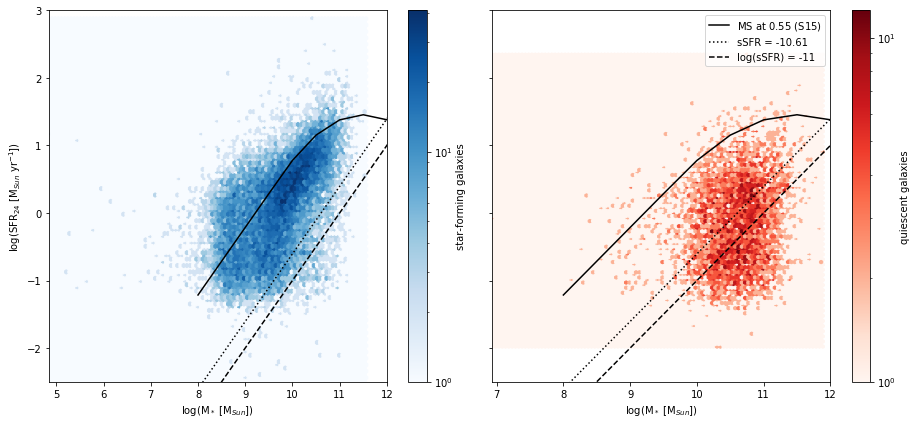

In [32]:
#%% Plotting Star formation rate vs Stellar mass
fig, axs = plt.subplots(1,2,sharey='row',figsize=(13,6))
axs[0].set_xlabel("log(M$_*$ [M$_{Sun}$])",fontsize=10)
axs[0].set_ylabel("log(SFR$_{24}$ [M$_{Sun}$ yr$^{-1}$])",fontsize=10)
hb = axs[0].hexbin(bootes.query('(0.5<Z_BEST<0.6)&'+SF).loc[:,'Mass_median'],
            np.log10(bootes.query('(0.5<Z_BEST<0.6)&'+SF).loc[:,'SFR_24']),
            cmap='Blues',bins='log')
cb = fig.colorbar(hb, ax=axs[0])
cb.set_label('star-forming galaxies')
axs[0].plot( m+9, logSFR, ls='-', c='k', label=f'MS at ${z}$ (S15)')
axs[0].plot([8,13],[8+age_factor,13+age_factor],':',color='k',label=f'sSFR = {age_factor:.4g}')
axs[0].plot([8,13],[-3,2],'--',color='k',label='log(sSFR) = -11')
axs[0].set_xlim(xmax=12)

axs[1].set_xlabel("log(M$_*$ [M$_{Sun}$])",fontsize=10)
hb = axs[1].hexbin(bootes.query('(0.5<Z_BEST<0.6)&'+quiescent).loc[:,'Mass_median'],
            np.log10(bootes.query('(0.5<Z_BEST<0.6)&'+quiescent).loc[:,'SFR_24']),
            cmap='Reds',bins='log')
cb = fig.colorbar(hb, ax=axs[1])
cb.set_label('quiescent galaxies')
axs[1].plot( m+9, logSFR, ls='-', c='k', label=f'MS at ${z}$ (S15)')
axs[1].plot([8,13],[8+age_factor,13+age_factor],':',color='k',label=f'sSFR = {age_factor:.4g}')
axs[1].plot([8,13],[-3,2],'--',color='k',label='log(sSFR) = -11')
axs[1].set_xlim(xmax=12)
axs[1].set_ylim(ymin=-2.5,ymax=3)
axs[1].legend(numpoints=1, loc='best')
fig.tight_layout()
plt.show()

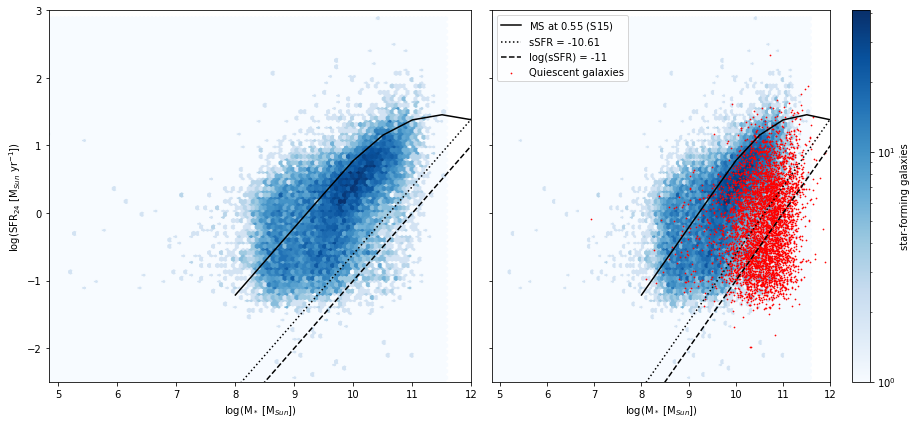

In [33]:
#%% Plotting Star formation rate vs Stellar mass
fig, axs = plt.subplots(1,2,sharey='row',figsize=(13,6))
axs[0].set_xlabel("log(M$_*$ [M$_{Sun}$])",fontsize=10)
axs[0].set_ylabel("log(SFR$_{24}$ [M$_{Sun}$ yr$^{-1}$])",fontsize=10)
hb = axs[0].hexbin(bootes.query('(0.5<Z_BEST<0.6)&'+SF).loc[:,'Mass_median'],
            np.log10(bootes.query('(0.5<Z_BEST<0.6)&'+SF).loc[:,'SFR_24']),
            cmap='Blues',bins='log')
axs[0].plot( m+9, logSFR, ls='-', c='k', label=f'MS at ${z}$ (S15)')
axs[0].plot([8,13],[8+age_factor,13+age_factor],':',color='k',label=f'sSFR = {age_factor:.4g}')
axs[0].plot([8,13],[-3,2],'--',color='k',label='log(sSFR) = -11')
axs[0].set_xlim(xmax=12)

axs[1].set_xlabel("log(M$_*$ [M$_{Sun}$])",fontsize=10)
hb = axs[1].hexbin(bootes.query('(0.5<Z_BEST<0.6)&'+SF).loc[:,'Mass_median'],
            np.log10(bootes.query('(0.5<Z_BEST<0.6)&'+SF).loc[:,'SFR_24']),
            cmap='Blues',bins='log')
cb = fig.colorbar(hb, ax=axs[1])
cb.set_label('star-forming galaxies')
axs[1].scatter(bootes.query('(0.5<Z_BEST<0.6)&'+quiescent).loc[:,'Mass_median'],
            np.log10(bootes.query('(0.5<Z_BEST<0.6)&'+quiescent).loc[:,'SFR_24']),
            s=0.5,color='r',label='Quiescent galaxies')
axs[1].plot( m+9, logSFR, ls='-', c='k', label=f'MS at ${z}$ (S15)')
axs[1].plot([8,13],[8+age_factor,13+age_factor],':',color='k',label=f'sSFR = {age_factor:.4g}')
axs[1].plot([8,13],[-3,2],'--',color='k',label='log(sSFR) = -11')
axs[1].set_xlim(xmax=12)
axs[1].set_ylim(ymin=-2.5,ymax=3)
axs[1].legend(numpoints=1, loc='best')
fig.tight_layout()
plt.show()

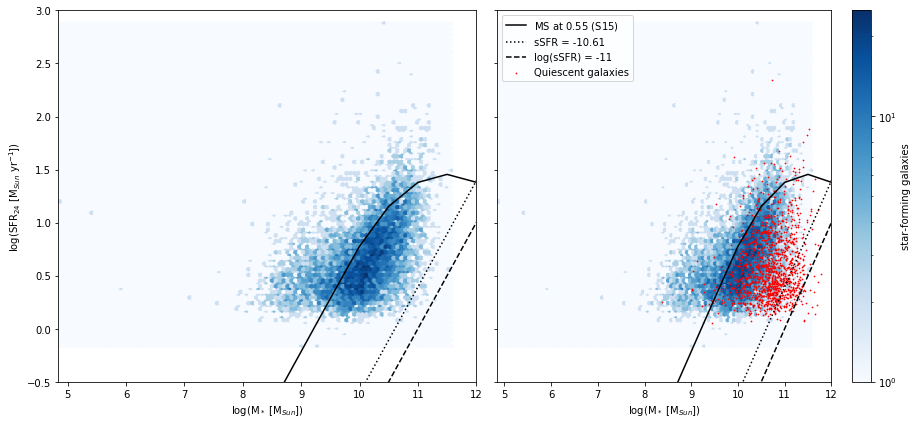

In [39]:
#%% Plotting Star formation rate vs Stellar mass
fig, axs = plt.subplots(1,2,sharey='row',figsize=(13,6))
axs[0].set_xlabel("log(M$_*$ [M$_{Sun}$])",fontsize=10)
axs[0].set_ylabel("log(SFR$_{24}$ [M$_{Sun}$ yr$^{-1}$])",fontsize=10)
hb = axs[0].hexbin(bootes.query('(0.5<Z_BEST<0.6)&'+SF+'&'+MIPSSNR3).loc[:,'Mass_median'],
            np.log10(bootes.query('(0.5<Z_BEST<0.6)&'+SF+'&'+MIPSSNR3).loc[:,'SFR_24']),
            cmap='Blues',bins='log')
axs[0].plot( m+9, logSFR, ls='-', c='k', label=f'MS at ${z}$ (S15)')
axs[0].plot([8,13],[8+age_factor,13+age_factor],':',color='k',label=f'sSFR = {age_factor:.4g}')
axs[0].plot([8,13],[-3,2],'--',color='k',label='log(sSFR) = -11')
axs[0].set_xlim(xmax=12)

axs[1].set_xlabel("log(M$_*$ [M$_{Sun}$])",fontsize=10)
hb = axs[1].hexbin(bootes.query('(0.5<Z_BEST<0.6)&'+SF+'&'+MIPSSNR3).loc[:,'Mass_median'],
            np.log10(bootes.query('(0.5<Z_BEST<0.6)&'+SF+'&'+MIPSSNR3).loc[:,'SFR_24']),
            cmap='Blues',bins='log')
cb = fig.colorbar(hb, ax=axs[1])
cb.set_label('star-forming galaxies')
axs[1].scatter(bootes.query('(0.5<Z_BEST<0.6)&'+quiescent+'&'+MIPSSNR3).loc[:,'Mass_median'],
            np.log10(bootes.query('(0.5<Z_BEST<0.6)&'+quiescent+'&'+MIPSSNR3).loc[:,'SFR_24']),
            s=0.5,color='r',label='Quiescent galaxies')
axs[1].plot( m+9, logSFR, ls='-', c='k', label=f'MS at ${z}$ (S15)')
axs[1].plot([8,13],[8+age_factor,13+age_factor],':',color='k',label=f'sSFR = {age_factor:.4g}')
axs[1].plot([8,13],[-3,2],'--',color='k',label='log(sSFR) = -11')
axs[1].set_xlim(xmax=12)
axs[1].set_ylim(ymin=-0.5,ymax=3)
axs[1].legend(numpoints=1, loc='best')
fig.tight_layout()
plt.show()

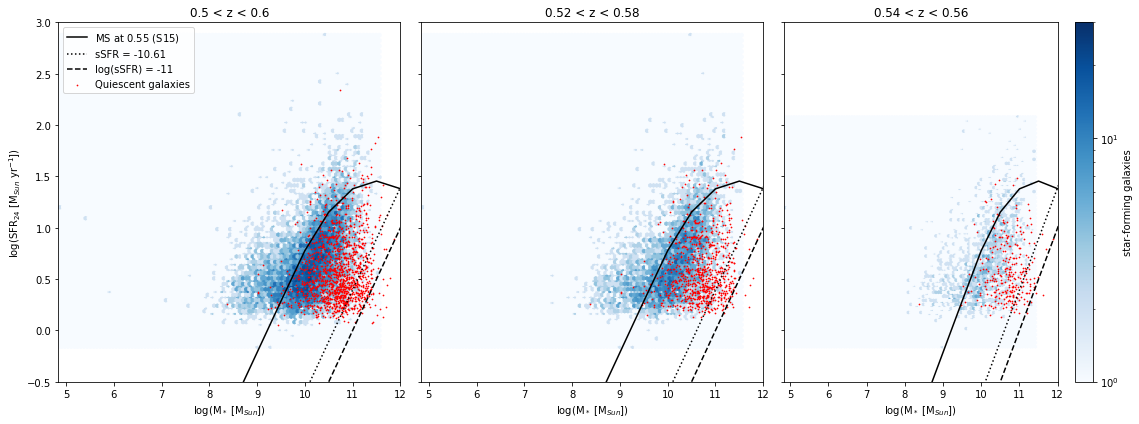

In [40]:
fig, axs = plt.subplots(1,3,sharey='row',figsize=(16,6))
fig.subplots_adjust(wspace=0)
for n, zmin, zmax in zip([0,1,2],[0.5,0.52,0.54],[0.6,0.58,0.56]):
    axs[n].set_xlabel("log(M$_*$ [M$_{Sun}$])",fontsize=10)
    
    bootes.query(f"{zmin}<=Z_BEST<={zmax}").loc[:,'RJ']
    
    hb = axs[n].hexbin(bootes.query(f"({zmin}<=Z_BEST<={zmax})&"+SF+'&'+MIPSSNR3).loc[:,'Mass_median'],
                       np.log10(bootes.query(f"({zmin}<=Z_BEST<={zmax})&"+SF+'&'+MIPSSNR3).loc[:,'SFR_24']),
                       cmap='Blues',bins='log',vmax=30)
    axs[n].scatter(bootes.query(f"({zmin}<=Z_BEST<={zmax})&"+quiescent+'&'+MIPSSNR3).loc[:,'Mass_median'],
                   np.log10(bootes.query(f"({zmin}<=Z_BEST<={zmax})&"+quiescent+'&'+MIPSSNR3).loc[:,'SFR_24']),
                   s=0.5,color='r',label='Quiescent galaxies')
    axs[n].plot( m+9, logSFR, ls='-', c='k', label=f'MS at ${z}$ (S15)')
    axs[n].plot([8,13],[8+age_factor,13+age_factor],':',color='k',label=f'sSFR = {age_factor:.4g}')
    axs[n].plot([8,13],[-3,2],'--',color='k',label='log(sSFR) = -11')
    axs[n].set_xlim(xmax=12)
    axs[n].set_ylim(ymin=-0.5,ymax=3)
    axs[n].set_title(f"{zmin} < z < {zmax}")

cb = fig.colorbar(hb, ax=axs[2])
cb.set_label('star-forming galaxies')
axs[0].set_ylabel("log(SFR$_{24}$ [M$_{Sun}$ yr$^{-1}$])",fontsize=10)
axs[0].legend(numpoints=1, loc='best')
fig.tight_layout()
plt.show()

## Herschel data
We can now check the number of entries wich have available data in the 2 PACS and 3 SPIRE bands from the Herschel space telescope.

In [43]:
q_PACS = len(bootes.query(quiescent).loc[np.isfinite(bootes['F_PACS_100']),:])
print(f"Fraction of quiescent galaxies with PACS data: {q_PACS/n_quiescent:.2%}")
sf_PACS = len(bootes.query(SF).loc[np.isfinite(bootes['F_PACS_100']),:])
print(f"Fraction of star forming galaxies with PACS data: {sf_PACS/n_star_forming:.2%}")
print("")
q_SPIRE = len(bootes.query(quiescent).loc[np.isfinite(bootes['F_SPIRE_500']),:])
print(f"Fraction of quiescent galaxies with SPIRE data: {q_SPIRE/n_quiescent:.2%}")
sf_SPIRE = len(bootes.query(SF).loc[np.isfinite(bootes['F_SPIRE_500']),:])
print(f"Fraction of star forming galaxies with SPIRE data: {sf_SPIRE/n_star_forming:.2%}")

Fraction of quiescent galaxies with PACS data: 41.40%
Fraction of star forming galaxies with PACS data: 39.68%

Fraction of quiescent galaxies with SPIRE data: 42.81%
Fraction of star forming galaxies with SPIRE data: 41.29%


# END NOTEBOOK HERE

## Getting rid of luminous AGN

We will now discard luminous AGN which may be contaminating our primarily star-forming sample. 

In [44]:
bootes['x'] = np.log10(bootes['ch3_flux']/bootes['ch1_flux'])
bootes['y'] = np.log10(bootes['ch4_flux']/bootes['ch2_flux'])

DonleyAGN=np.count_nonzero((bootes['x']>=0.08)&
                           (bootes['y']>=0.15)&
                           (bootes['y']>=1.21*bootes['x']-0.27)&
                           (bootes['y']<=1.21*bootes['x']+0.27)&
                           (bootes['ch2_flux']>bootes['ch1_flux'])&
                           (bootes['ch3_flux']>bootes['ch2_flux'])&
                           (bootes['ch4_flux']>bootes['ch3_flux']))

print(f"Galaxies marked as AGN in the catalogue: {np.count_nonzero(bootes['AGN']==1)}")
print(f"Galaxies that meet the Donley et al. (2012) IR AGN criteria: {DonleyAGN}")

Galaxies marked as AGN in the catalogue: 127
Galaxies that meet the Donley et al. (2012) IR AGN criteria: 179


/home/bruno/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [45]:
np.count_nonzero((bootes['x']>=0.08)&
                           (bootes['y']>=0.15)&
                           (bootes['y']>=1.21*bootes['x']-0.27)&
                           (bootes['y']<=1.21*bootes['x']+0.27)&
                           (bootes['ch2_flux']>bootes['ch1_flux'])&
                           (bootes['ch3_flux']>bootes['ch2_flux'])&
                           (bootes['ch4_flux']>bootes['ch3_flux'])&(bootes['AGN']==1))

74

In [46]:
bootes = bootes[~((bootes['x']>=0.08)&
                           (bootes['y']>=0.15)&
                           (bootes['y']>=1.21*bootes['x']-0.27)&
                           (bootes['y']<=1.21*bootes['x']+0.27)&
                           (bootes['ch2_flux']>bootes['ch1_flux'])&
                           (bootes['ch3_flux']>bootes['ch2_flux'])&
                           (bootes['ch4_flux']>bootes['ch3_flux']))]

In [47]:
final_sample=len(bootes)
n_quiescent = len(bootes.query(quiescent))
n_star_forming = len(bootes.query(SF))
print(f"Number of galaxies in sample: {final_sample}")
print(f"Number of quiescent galaxies in the sample: {n_quiescent}")
q_mass = len(bootes.query(quiescent).loc[np.isfinite(bootes['Mass_median']),:])
print(f"Fraction of quiescent galaxies with stellar mass data: {q_mass/n_quiescent:.2%}")
q_MIPS = len(bootes.query(quiescent).loc[np.isfinite(bootes['F_MIPS_24']),:])
print(f"Fraction of quiescent galaxies with MIPS data: {q_MIPS/n_quiescent:.2%}")
q_MIPSgt0 = len(bootes.query(quiescent+'&(F_MIPS_24>0)'))
print(f"Fraction of quiescent galaxies with MIPS flux > 0 uJy: {q_MIPSgt0/n_quiescent:.2%}")
q_MIPSSN = len(bootes.query(quiescent+'&'+MIPSSNR3))
print(f"Fraction of quiescent galaxies with MIPS S/N > 3: {q_MIPSSN/n_quiescent:.2%}")
q_MIPSSN = len(bootes.query(quiescent+'&'+MIPSSNR5))
print(f"Fraction of quiescent galaxies with MIPS S/N > 5: {q_MIPSSN/n_quiescent:.2%}")
print("")
print(f"Number of star-forming galaxies in the sample: {n_star_forming}")
sf_mass = len(bootes.query(SF).loc[np.isfinite(bootes['Mass_median']),:])
print(f"Fraction of star-forming galaxies with stellar mass data: {sf_mass/n_star_forming:.2%}")
sf_MIPS = len(bootes.query(SF).loc[np.isfinite(bootes['F_MIPS_24']),:])
print(f"Fraction of star-forming galaxies with MIPS data: {sf_MIPS/n_star_forming:.2%}")
sf_MIPSgt0 = len(bootes.query(SF+'&(F_MIPS_24>0)'))
print(f"Fraction of star-forming galaxies with MIPS flux > 0 uJy: {sf_MIPSgt0/n_star_forming:.2%}")
sf_MIPSSN = len(bootes.query(SF+'&'+MIPSSNR3))
print(f"Fraction of star-forming galaxies with MIPS S/N > 3: {sf_MIPSSN/n_star_forming:.2%}")
sf_MIPSSN = len(bootes.query(SF+'&'+MIPSSNR5))
print(f"Fraction of star-forming galaxies with MIPS S/N > 5: {sf_MIPSSN/n_star_forming:.2%}")

Number of galaxies in sample: 33397
Number of quiescent galaxies in the sample: 5380
Fraction of quiescent galaxies with stellar mass data: 100.00%
Fraction of quiescent galaxies with MIPS data: 93.72%
Fraction of quiescent galaxies with MIPS flux > 0 uJy: 83.59%
Fraction of quiescent galaxies with MIPS S/N > 3: 25.11%
Fraction of quiescent galaxies with MIPS S/N > 5: 14.50%

Number of star-forming galaxies in the sample: 28017
Fraction of star-forming galaxies with stellar mass data: 100.00%
Fraction of star-forming galaxies with MIPS data: 92.40%
Fraction of star-forming galaxies with MIPS flux > 0 uJy: 64.96%
Fraction of star-forming galaxies with MIPS S/N > 3: 27.85%
Fraction of star-forming galaxies with MIPS S/N > 5: 18.97%


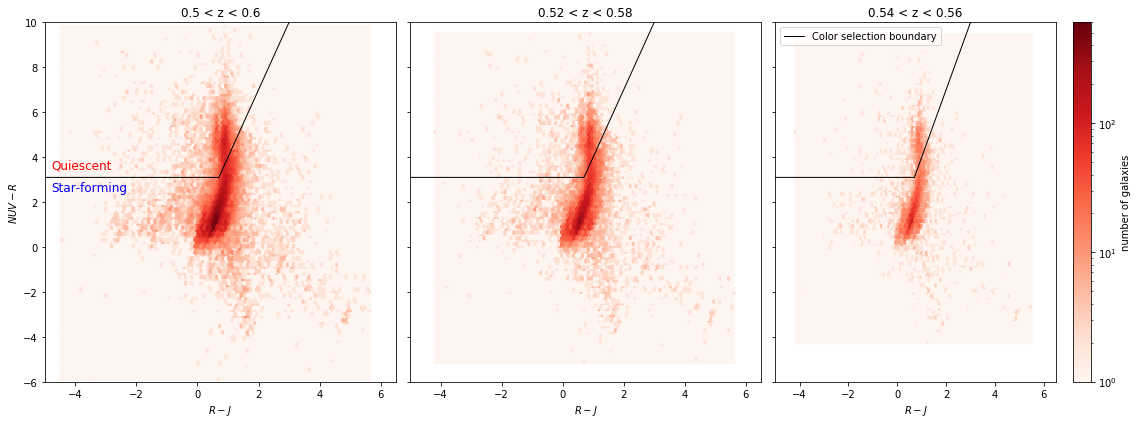

In [49]:
fig, axs = plt.subplots(1,3,sharey='row',figsize=(16,6))
#fig.suptitle('Color-color diagrams for different redshift bins')
fig.subplots_adjust(wspace=0)
for n, zmin, zmax in zip([0,1,2],[0.5,0.52,0.54],[0.6,0.58,0.56]):
    axs[n].set_xlabel(f"${filter2}-{filter3}$",fontsize=10)
    #xdata = bootes.loc[(bootes['Z_BEST']>=zmin)&(bootes['Z_BEST']<zmax),'RJ']
    #ydata = bootes.loc[(bootes['Z_BEST']>=zmin)&(bootes['Z_BEST']<zmax),'NUVR']
    xdata = bootes.query(f"{zmin}<=Z_BEST<={zmax}").loc[:,'RJ']
    ydata = bootes.query(f"{zmin}<=Z_BEST<={zmax}").loc[:,'NUVR']
    hb = axs[n].hexbin(xdata,ydata,bins='log',cmap='Reds',vmax=600)
    axs[n].plot([-80,0.7,80],[3.1,3.1,241],color='k',linewidth=1,label='Color selection boundary')
    axs[n].set_xlim(xmin=-5,xmax=6.5)
    axs[n].set_ylim(ymin=-6,ymax=10)
    axs[n].set_title(f"{zmin} < z < {zmax}")
cb = fig.colorbar(hb, ax=axs[2])
cb.set_label('number of galaxies')
axs[0].set_ylabel(f"${filter1}-{filter2}$",fontsize=10)
axs[2].legend(numpoints=1, loc='best')
axs[0].text(-4.8,3.5,'Quiescent',size=12,color='r')
axs[0].text(-4.8,2.5,'Star-forming',size=12,color='b')
fig.tight_layout()
plt.show()

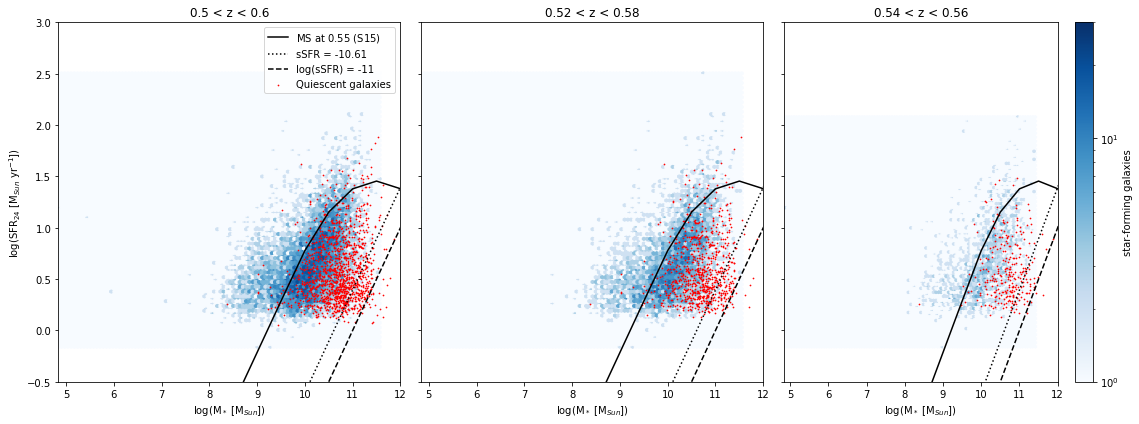

In [50]:
fig, axs = plt.subplots(1,3,sharey='row',figsize=(16,6))
fig.subplots_adjust(wspace=0)
for n, zmin, zmax in zip([0,1,2],[0.5,0.52,0.54],[0.6,0.58,0.56]):
    axs[n].set_xlabel("log(M$_*$ [M$_{Sun}$])",fontsize=10)
    
    bootes.query(f"{zmin}<=Z_BEST<={zmax}").loc[:,'RJ']
    
    hb = axs[n].hexbin(bootes.query(f"({zmin}<=Z_BEST<={zmax})&"+SF+'&'+MIPSSNR3).loc[:,'Mass_median'],
                       np.log10(bootes.query(f"({zmin}<=Z_BEST<={zmax})&"+SF+'&'+MIPSSNR3).loc[:,'SFR_24']),
                       cmap='Blues',bins='log',vmax=30)
    axs[n].scatter(bootes.query(f"({zmin}<=Z_BEST<={zmax})&"+quiescent+'&'+MIPSSNR3).loc[:,'Mass_median'],
                   np.log10(bootes.query(f"({zmin}<=Z_BEST<={zmax})&"+quiescent+'&'+MIPSSNR3).loc[:,'SFR_24']),
                   s=0.5,color='r',label='Quiescent galaxies')
    axs[n].plot( m+9, logSFR, ls='-', c='k', label=f'MS at ${z}$ (S15)')
    axs[n].plot([8,13],[8+age_factor,13+age_factor],':',color='k',label=f'sSFR = {age_factor:.4g}')
    axs[n].plot([8,13],[-3,2],'--',color='k',label='log(sSFR) = -11')
    axs[n].set_xlim(xmax=12)
    axs[n].set_ylim(ymin=-0.5,ymax=3)
    axs[n].set_title(f"{zmin} < z < {zmax}")

cb = fig.colorbar(hb, ax=axs[2])
cb.set_label('star-forming galaxies')
axs[0].set_ylabel("log(SFR$_{24}$ [M$_{Sun}$ yr$^{-1}$])",fontsize=10)
axs[0].legend(numpoints=1, loc='best')
fig.tight_layout()
plt.show()

In [54]:
end_time=time()
print("Running notebook took {:.4g} seconds!".format(end_time-start_time))

Running notebook took 2841 seconds!
